# AML Homework 3: Practice


*Group members:*  

1. *Ciciani Diego (2140394)*  
   - *Email*: ciciani.2140394@studenti.uniroma1.it  

2. *Cesario Laura Thoft (1852596)*  
   - *Email*: cesario.1852596@studenti.uniroma1.it  

3. *Oddi Livia (1846085)*  
   - *Email*: oddi.1846085@studenti.uniroma1.it  

4. *Zeller Damian (2118831)*  
   - *Email*: zeller.2118831@studenti.uniroma1.it

### ***Disclaimer***
Since we do not have GPU usage available all day (actually it's just for a few hours) we had to modify some `torch.load()` code by inserting `map_location=torch.device('cpu')` to be able to finish the homework.

## Table of contents:
This notebook is composed of 7 Sections for 17 points

* **Section 1: Train a CNN from Scratch on CIFAR-10 ( 2 Points)**

    We will implement a Convolutional Neural Network (CNN) from the ground up to classify images from the CIFAR-10 dataset. The focus will be on understanding the architecture of CNNs, preprocessing the dataset, and optimizing the model to achieve high accuracy.

* **Section 2: Unlearning( 2 Points)**

    We introduce the concept of unlearning, which involves modifying a trained model to forget specific data points while retaining its overall performance.

* **Section 3: Gold model ( 2 Points)**

    We discuss the development of the Gold model, which serves as the benchmark for evaluating performance after implementing unlearning techniques.


* **Section 4: Mia Attacks ( 3 Points)**

    This section will focus on MIA (Membership Inference Attacks), which are designed to determine whether a specific data point was included in the training set of a machine learning model.
    
* **Section 5: Unlearning with KL divergence ( 2 Points)**

    This section will discuss the application of Kullback-Leibler (KL) divergence in the unlearning process, emphasizing its role in quantifying the difference between the model's original and modified predictions.

* **Section 6: GMN for Unlearning ( 6 Points)**

    This section will introduce the use of Graph Meta Networks (GMNs) in the unlearning process, highlighting their ability to adaptively modify model parameters based on specific unlearning tasks.

Do not modify parts of code that are not marked with "Your turn" or "Add your code below".

In [1]:
%pip install torch
%pip install torch_geometric
%pip install pyEDM

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\Livia_99\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\Livia_99\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\Livia_99\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
%pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\Livia_99\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import random
from sklearn import linear_model, model_selection
from torch_geometric.data import Data
from gmn.graph_construct.model_arch_graph import sequential_to_arch, arch_to_graph
import torch.nn.functional as F


#fix seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Section 1: Train from scratch a CNN on CIFAR-10

### 1.1: Model definition

In [4]:
def create_model():
    '''
    Create a simple CNN model for CIFAR10 dataset
    '''

    model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.1),

        nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.1),

        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d((1,1)),
        nn.Flatten(),
        nn.Dropout(p=0.1),

        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(p=0.1),

        nn.Linear(32, 10)
    )

    return model

### 1.2 DataLoader


#### Your turn ( 1 Point)

Calculate the mean and the standard deviation vectors to be used in cifar_transforms  rounding the values to four decimal places.

In [5]:
import numpy as np
from torchvision import datasets, transforms

# Load the dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

'''
Add your code below
'''
# Compute the mean and standard deviation for each channel
mean = np.mean(train_dataset.data, axis=(0, 1, 2)) / 255.0
std = np.std(train_dataset.data, axis=(0, 1, 2)) / 255.0
#axis = (0,1,2) -> ensures that we're computing the mean and standard deviation across the entire dataset for each channel separately.
#division by 255.0 -> normalizing the pixel values to the range [0, 1] (common preprocessing when dealing with images)

print("Mean: ", np.round(mean, 4))
print("Std: ", np.round(std, 4))

Files already downloaded and verified
Mean:  [0.4914 0.4822 0.4465]
Std:  [0.247  0.2435 0.2616]


In [6]:
# Define the augmentations for the training set
cifar_transforms = transforms.Compose([
    transforms.ToTensor(),                    # Convert the image to a PyTorch tensor
    transforms.Normalize(mean, std), # Normalize the image channel
])

# Load the CIFAR-10 dataset with the appropriate transforms
train_dataset = datasets.CIFAR10(root="data", train=True, transform=cifar_transforms, download=True)
test_dataset = datasets.CIFAR10(root="data", train=False, transform=cifar_transforms, download=True)

#split test into test and validation
val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [2000, 8000])

Files already downloaded and verified
Files already downloaded and verified


In [7]:
batch_size = 512

# Create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

### 1.3 See the data

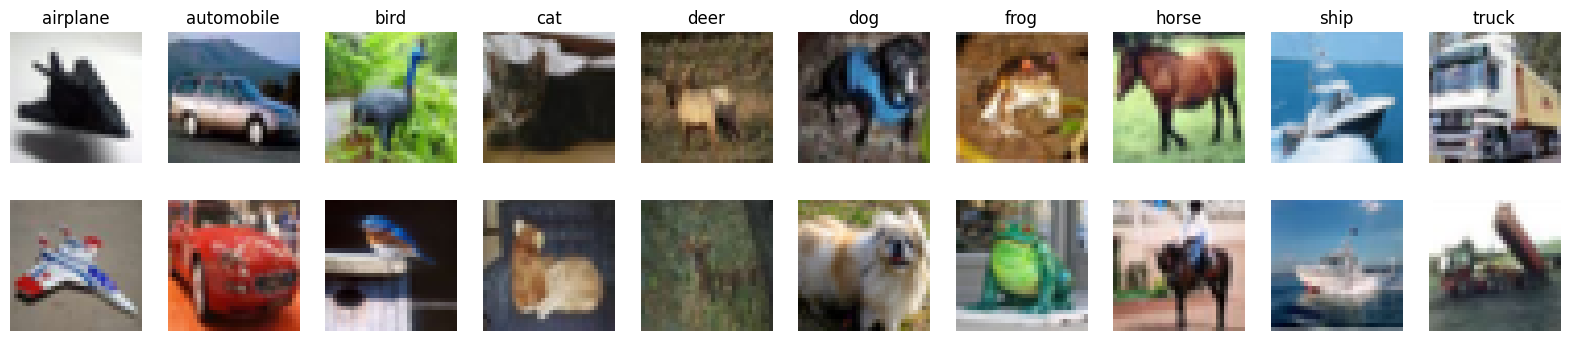

In [8]:
# plot 2 figures for each of the 10 classes in the dataset
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    # Get the first image of each class
    img = train_dataset.data[train_dataset.targets.index(i)]
    axs[0, i].imshow(img)
    axs[0, i].axis('off')
    axs[0, i].set_title(train_dataset.classes[i])

    # Get the second image of each class
    img = train_dataset.data[train_dataset.targets.index(i, train_dataset.targets.index(i) + 1)]
    axs[1, i].imshow(img)
    axs[1, i].axis('off')

### 1.4: Training Loop

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#load weights
model = create_model()
model.load_state_dict(torch.load('./checkpoint/model_weights.pth'))
model.to(device);

# initialize the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 20


C:\Users\Livia_99\AppData\Local\Temp\ipykernel_2272\3872289120.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./checkpoint/model_weigh

In [10]:
# Placeholder for storing losses for each epoch
losses = []
losses_val = []

# Training the model
for epoch in range(num_epochs):

    ######### TRAINING ##########
    model.train()
    running_loss = 0  # To track loss for this epoch

    # Using tqdm for the progress bar
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)

    for batch_idx, (data, targets) in loop:
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Forward pass
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent step
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

        # Update progress bar with loss and epoch information
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

    # Calculate average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)

    #scheduler
    scheduler.step(avg_loss)

    # Print loss for this epoch
    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

    ####### VALIDATION ########
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for data, targets in val_loader:
            data = data.to(device=device)
            targets = targets.to(device=device)

            scores = model(data)
            loss = criterion(scores, targets)
            val_loss += loss.item()
        # Calculate average loss for the epoch
        avg_val_loss = val_loss / len(val_loader)
        losses_val.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.4f}")
        # if avg val_loss is better than the one before, save the model
        if epoch == 0:
            # create directory if not exist
            os.makedirs("checkpoint", exist_ok=True)
            best_loss = avg_val_loss
            torch.save(model.state_dict(), "checkpoint/trained_model.pth")
        elif avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), "checkpoint/trained_model.pth")



Epoch [1/20]: 100%|██████████| 98/98 [00:22<00:00,  4.39it/s, loss=1.55]


Epoch [1/20], Average Loss: 1.8865
Validation Loss: 1.6026


Epoch [2/20]: 100%|██████████| 98/98 [00:24<00:00,  3.92it/s, loss=1.41]


Epoch [2/20], Average Loss: 1.4528
Validation Loss: 1.4044


Epoch [3/20]: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s, loss=1.23]


Epoch [3/20], Average Loss: 1.3163
Validation Loss: 1.2337


Epoch [4/20]: 100%|██████████| 98/98 [00:24<00:00,  4.05it/s, loss=1.21]


Epoch [4/20], Average Loss: 1.2407
Validation Loss: 1.1593


Epoch [5/20]: 100%|██████████| 98/98 [00:24<00:00,  4.01it/s, loss=1.15]


Epoch [5/20], Average Loss: 1.1892
Validation Loss: 1.1709


Epoch [6/20]: 100%|██████████| 98/98 [00:24<00:00,  4.04it/s, loss=1.09]


Epoch [6/20], Average Loss: 1.1550
Validation Loss: 1.2492


Epoch [7/20]: 100%|██████████| 98/98 [00:24<00:00,  4.02it/s, loss=1.08]


Epoch [7/20], Average Loss: 1.1251
Validation Loss: 1.1328


Epoch [8/20]: 100%|██████████| 98/98 [00:24<00:00,  4.02it/s, loss=1.04] 


Epoch [8/20], Average Loss: 1.1000
Validation Loss: 1.0867


Epoch [9/20]: 100%|██████████| 98/98 [00:24<00:00,  4.03it/s, loss=1.01] 


Epoch [9/20], Average Loss: 1.0775
Validation Loss: 1.0525


Epoch [10/20]: 100%|██████████| 98/98 [00:25<00:00,  3.88it/s, loss=1.05] 


Epoch [10/20], Average Loss: 1.0568
Validation Loss: 1.0633


Epoch [11/20]: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s, loss=1.07] 


Epoch [11/20], Average Loss: 1.0425
Validation Loss: 1.0002


Epoch [12/20]: 100%|██████████| 98/98 [00:24<00:00,  3.92it/s, loss=1.03] 


Epoch [12/20], Average Loss: 1.0178
Validation Loss: 0.9718


Epoch [13/20]: 100%|██████████| 98/98 [00:25<00:00,  3.91it/s, loss=1.02] 


Epoch [13/20], Average Loss: 1.0080
Validation Loss: 0.9075


Epoch [14/20]: 100%|██████████| 98/98 [00:24<00:00,  3.97it/s, loss=0.942]


Epoch [14/20], Average Loss: 1.0018
Validation Loss: 0.9255


Epoch [15/20]: 100%|██████████| 98/98 [00:24<00:00,  4.02it/s, loss=0.969]


Epoch [15/20], Average Loss: 0.9818
Validation Loss: 1.0042


Epoch [16/20]: 100%|██████████| 98/98 [00:27<00:00,  3.57it/s, loss=0.962]


Epoch [16/20], Average Loss: 0.9706
Validation Loss: 0.8951


Epoch [17/20]: 100%|██████████| 98/98 [00:35<00:00,  2.77it/s, loss=0.954]


Epoch [17/20], Average Loss: 0.9542
Validation Loss: 0.9426


Epoch [18/20]: 100%|██████████| 98/98 [00:24<00:00,  4.01it/s, loss=0.952]


Epoch [18/20], Average Loss: 0.9361
Validation Loss: 0.8746


Epoch [19/20]: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s, loss=0.843]


Epoch [19/20], Average Loss: 0.9332
Validation Loss: 0.9319


Epoch [20/20]: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s, loss=0.941]


Epoch [20/20], Average Loss: 0.9243
Validation Loss: 0.9725


Best validation loss: 0.8746


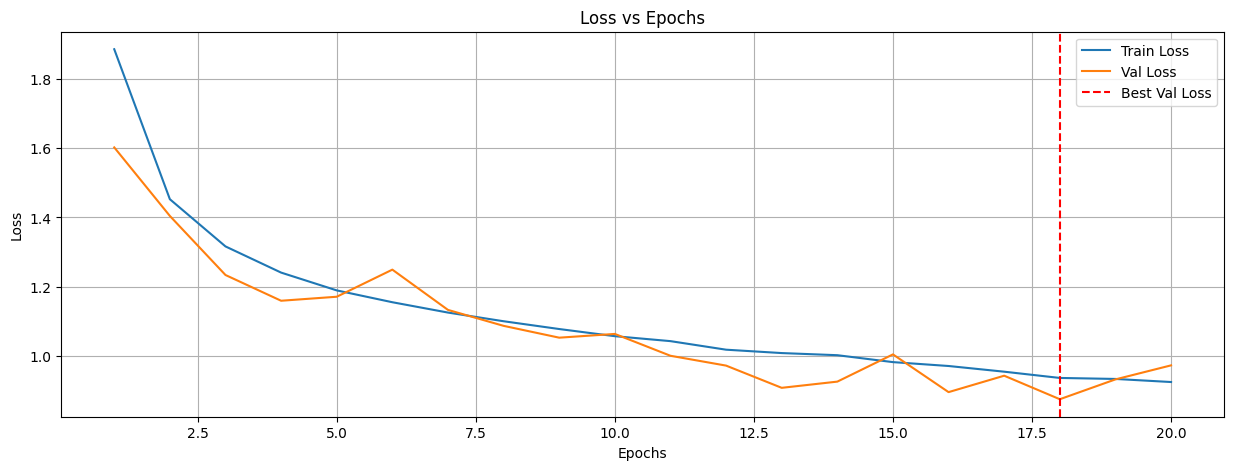

In [11]:
# Plot the losses after training
# epoch of best validation loss
print(f"Best validation loss: {best_loss:.4f}")
index_best = losses_val.index(best_loss)

plt.figure(figsize=(15, 5))
plt.plot(range(1,num_epochs+1), losses, label="Train Loss")
plt.plot(range(1,num_epochs+1), losses_val, label="Val Loss")
plt.axvline(index_best+1, color='r', linestyle='--', label="Best Val Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

#### Your Turn (1 point)

**Question**

Q: *Based on what you've learned in the lectures and by examining the image above, identify the problems with this plot and explain how to fix them.*

A:<br>
Based on the analysis of the provided ***`Loss vs. Epoch`*** plot, two main issues can be identified:

1. **Divergence Between Training and Validation Losses**:  
   While the training loss steadily decreases, the validation loss does not follow the same trend. After reaching its lowest point (indicated by the red dashed line), the validation loss begins to rise, suggesting a divergence between training and validation performance.

2. **Instability in Validation Loss**:  
   The validation loss shows significant fluctuations and spikes, particularly around epochs 6, 15, and 18, indicating instability. Due to this instability, it’s possible that the best validation loss (currently shown around epoch 19) could occur earlier in training.

These issues indicate signs of overfitting and possible problems with hyperparameters like the learning rate or batch size, as seen in the validation loss spikes. However, a `learning rate scheduler` is already in place, which should mitigate learning rate issues, and the current batch size (512) appears appropriate based on prior experimentation.

To address these problems, we could:
- Apply **regularization techniques** (such as dropout or L2 regularization) to improve generalization.
- Implement **early stopping** to halt training based on validation loss.
- **Increase the number of epochs** to allow more time for full convergence if overfitting stabilizes.

While **reducing the learning rate** is a common approach, it may not be necessary here given the learning rate scheduler already in use.

### 1.5 Evaluation

Now, let's evaluate the performances of our model

In [12]:
# accuracy
def accuracy (model, loader):
    '''
    Function to calculate the accuracy of the model on the test set
    '''
    correct = 0
    total = 0
    for data, targets in loader:
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        _, predictions = scores.max(1)
        correct += (predictions == targets).sum()
        total += targets.shape[0]
    return correct / total

In [13]:
# your model
model = create_model()
model.load_state_dict(torch.load('./checkpoint/trained_model.pth'))
model.eval()
model.to(device)

# Calculate accuracy on the train and test set
train_accuracy = accuracy(model, train_loader)
test_accuracy = accuracy(model, test_loader)

print(f"Your Model Train Accuracy : {100* train_accuracy:.4f}")
print(f"Your Model Test Accuracy : {100* test_accuracy:.4f}")

C:\Users\Livia_99\AppData\Local\Temp\ipykernel_2272\925873892.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./checkpoint/trained_mode

Your Model Train Accuracy : 70.1920
Your Model Test Accuracy : 68.7750


To avoid training for too many epochs, here it is a checkpoint you can use for the trained model.

In [14]:
model = create_model()
model.load_state_dict(torch.load("./checkpoint/best_model.pth", map_location=torch.device('cpu'))) #when running with cpu
model.eval()
model.to(device)

# Calculate the accuracy on the train and test set
train_accuracy = accuracy(model, train_loader)
test_accuracy = accuracy(model, test_loader)

print(f"Train accuracy: {100* train_accuracy:.4f}")
print(f"Test Accuracy: {100* test_accuracy:.4f}")

C:\Users\Livia_99\AppData\Local\Temp\ipykernel_2272\2361541384.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./checkpoint/best_model.

Train accuracy: 86.3800
Test Accuracy: 80.9000


# Section 2: Unlearning

In the context of machine learning, unlearning refers to the process of modifying a trained model so that it forgets specific pieces of information without losing the general performance. This is particularly important in situations where data privacy is a concern, such as when sensitive information is involved, or when a model has learned from outdated or incorrect data. In this scenario,
you may want to unlearn an entire class of data, a specific instance within that class, or even a particular concept that the model has learned.

**Why is Unlearning Important?**

Let’s say you have trained a machine learning model to recognize different types of animals based on a dataset containing images. Now, suppose that this dataset includes images of a particular cat breed that was later found to be misclassified or problematic. You might need to remove that specific information from the model to ensure it doesn't make incorrect predictions in the future.

Additionally, with privacy laws like GDPR (General Data Protection Regulation), individuals have the right to request that their personal data be removed from a model. If a model has been trained on this data, we need a way to unlearn it.

Here, our task will be to unlearn the class of Airplanes in CIFAR-10 Dataset

### Unlearning by Fine-Tuning

The Unlearning by Fine-Tuning strategy is a technique used to remove the influence of specific data points from a trained machine learning model while preserving its performance on other, relevant data.
Here’s a detailed explanation of how this strategy works:

#### 1. The Retain Set

The retain set consists of all the data points that you want the model to remember or continue to learn from. This set excludes the data points you want the model to forget.

####  2. Fine-Tuning Process

To perform unlearning through this strategy, you follow these steps:

- Identify and Remove the Data Points: First, identify the data points that you wish to unlearn and remove them from the training dataset.

- Prepare the Retain and Forget Set: Create a new training dataset that contains only the retain set, those data points that should be kept in the model’s knowledge, and include the remaing data in the Forget Set.

- Fine-Tuning on the Retain Set: Instead of retraining the model from scratch, you will fine-tune the existing model using the retain set. This involves using the retain set to continue training the model, typically with a lower learning rate to ensure that the model can adjust its parameters without drastically altering what it has already learned.

#### 3. Benefits of this strategy

- Efficiency: Fine-tuning on the retain set only is more efficient than retraining the model from scratch. It saves computational resources and time.

- Maintained Performance: The model retains its ability to perform well on the general dataset, as it continues to learn from the valid data in the retain set.

#### 4. Drawbacks of this strategy

- Even if more efficient than retraining the model from scratch, you still need to do a fine tuning, that could be very expensive for large or foundational models. Even finding the best hyperparameters can be costly.

- If you change samples or architecture to unlearn, you have to do the ad-hoc fine tuning again, it is not a *general* strategy.

### 2.1: Forget Airplanes

#### Your Turn ( 1 Point)

Generate the retain and forget datasets, keeping in mind that we want to forget the "airplanes" class. Afterward, create new instances of the loaders for training, validation, and testing. Make sure to use the torch.utils.data.Subset function.

In [15]:
#train
'''
Add your code below
'''
#To select the class to forget - CIFAR-10 class index for airplanes is 0

airplane_class_idx = 0
retain_indices = [i for i, (_, label) in enumerate(train_dataset) if label != airplane_class_idx]
forget_indices = [i for i, (_, label) in enumerate(train_dataset) if label == airplane_class_idx]

retain_dataset = torch.utils.data.Subset(train_dataset, retain_indices)
forget_dataset = torch.utils.data.Subset(train_dataset, forget_indices)
retain_loader =  DataLoader(retain_dataset, batch_size = batch_size, shuffle=True)
forget_loader =  DataLoader(forget_dataset, batch_size = batch_size, shuffle=True)

In [16]:
#validation
'''
Add your code below
'''
retain_indices_val = [i for i, (_, label) in enumerate(val_dataset) if label != airplane_class_idx]
forget_indices_val = [i for i, (_, label) in enumerate(val_dataset) if label == airplane_class_idx]

retain_dataset_val = torch.utils.data.Subset(val_dataset, retain_indices_val)
forget_dataset_val = torch.utils.data.Subset(val_dataset, forget_indices_val)
retain_loader_val =  DataLoader(retain_dataset_val, batch_size = batch_size, shuffle=False)
forget_loader_val =  DataLoader(forget_dataset_val, batch_size = batch_size, shuffle=False)

In [17]:
#test
'''
Add your code below
'''
retain_indices_test = [i for i, (_, label) in enumerate(test_dataset) if label != airplane_class_idx]
forget_indices_test = [i for i, (_, label) in enumerate(test_dataset) if label == airplane_class_idx]

retain_dataset_test = torch.utils.data.Subset(test_dataset, retain_indices_test)
forget_dataset_test = torch.utils.data.Subset(test_dataset, forget_indices_test)
retain_loader_test = DataLoader(retain_dataset_test, batch_size = batch_size, shuffle=False)
forget_loader_test = DataLoader(forget_dataset_test, batch_size = batch_size, shuffle=False)

### 2.2: Training Loop

In [18]:
def unlearning( model, retain_loader , validation, epochs = 5, criterion = criterion, optimizer = optimizer, scheduler = scheduler):
    """Unlearning by fine-tuning.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      model : nn.Module.
        pre-trained model to use as base of unlearning.
      retain : torch.utils.data.DataLoader.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      validation : torch.utils.data.DataLoader.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      model : updated model
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    losses = []
    losses_val = []

    for epoch in range(epochs):
        model.train()
        loss_epoch = 0
        loop = tqdm(enumerate(retain_loader), total=len(retain_loader), leave=True)
        for batch_idx, (inputs, targets) in loop:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            #running loss
            loss_epoch += loss.item()
            # Update progress bar with loss and epoch information
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item())

        #avg loss
        avg_loss = loss_epoch / len(retain_loader)
        losses.append(avg_loss)
        #scheduler step
        scheduler.step(avg_loss)
        tqdm.write(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}")

        # validation
        loss_val = 0
        model.eval()
        with torch.no_grad():
            for data, targets in validation:
                data = data.to(device=device)
                targets = targets.to(device=device)

                scores = model(data)
                loss = criterion(scores, targets)
                loss_val += loss.item()
            # Calculate average loss for the epoch
            avg_val_loss = loss_val / len(validation)
            losses_val.append(avg_val_loss)
            print(f"Validation Loss: {avg_val_loss:.4f}")
            # if avg val_loss is better than the one before, save the model
            if epoch == 0:
                # create directory if not exist
                os.makedirs("checkpoint", exist_ok=True)
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/forget_model.pth")
            elif avg_val_loss < best_loss:
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/forget_model.pth")


    model.eval()
    model.load_state_dict(torch.load("checkpoint/forget_model.pth"))
    return model, losses, losses_val

In [19]:
# intialize forget model as trained model
forget_model = create_model()
forget_model.load_state_dict(torch.load("./checkpoint/best_model.pth", map_location=torch.device('cpu'))) #when using cpu

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(forget_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)


# Unlearn the forget set
epochs = 10
forget_model, losses, losses_val = unlearning(forget_model, retain_loader, retain_loader_val, epochs=epochs, criterion=criterion, optimizer=optimizer, scheduler=scheduler)

C:\Users\Livia_99\AppData\Local\Temp\ipykernel_2272\2334815723.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  forget_model.load_state_dict(torch.load("./checkpoint/best

Epoch [1/10], Average Loss: 0.5257
Validation Loss: 0.5128


Epoch [2/10]: 100%|██████████| 88/88 [00:22<00:00,  3.89it/s, loss=0.5]  


Epoch [2/10], Average Loss: 0.5028
Validation Loss: 0.5087


Epoch [3/10]: 100%|██████████| 88/88 [00:22<00:00,  3.85it/s, loss=0.443]


Epoch [3/10], Average Loss: 0.4954
Validation Loss: 0.5023


Epoch [4/10]: 100%|██████████| 88/88 [00:22<00:00,  3.90it/s, loss=0.553]


Epoch [4/10], Average Loss: 0.4918
Validation Loss: 0.4971


Epoch [5/10]: 100%|██████████| 88/88 [00:23<00:00,  3.81it/s, loss=0.467]


Epoch [5/10], Average Loss: 0.4910
Validation Loss: 0.4985


Epoch [6/10]: 100%|██████████| 88/88 [00:22<00:00,  3.90it/s, loss=0.528]


Epoch [6/10], Average Loss: 0.4917
Validation Loss: 0.5021


Epoch [7/10]: 100%|██████████| 88/88 [00:22<00:00,  3.88it/s, loss=0.513]


Epoch [7/10], Average Loss: 0.4851
Validation Loss: 0.4946


Epoch [8/10]: 100%|██████████| 88/88 [00:22<00:00,  3.88it/s, loss=0.508]


Epoch [8/10], Average Loss: 0.4883
Validation Loss: 0.4963


Epoch [9/10]: 100%|██████████| 88/88 [00:23<00:00,  3.74it/s, loss=0.535]


Epoch [9/10], Average Loss: 0.4848
Validation Loss: 0.4965


Epoch [10/10]: 100%|██████████| 88/88 [00:22<00:00,  3.88it/s, loss=0.504]


Epoch [10/10], Average Loss: 0.4838
Validation Loss: 0.4992


C:\Users\Livia_99\AppData\Local\Temp\ipykernel_2272\2529405092.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint/forget_model

**Below there is the evaluation of your unlearned by fine-tuning model**

In [88]:
# load weights forget model
forget_model = create_model()
forget_model.load_state_dict(torch.load("./checkpoint/forget_model.pth"));
forget_model.eval()
forget_model.to(device);

# print accuracies on retain, forget and test set
retain_accuracy = accuracy(forget_model, retain_loader)
forget_accuracy = accuracy(forget_model, forget_loader)
test_accuracy = accuracy(forget_model, test_loader)
test_accuracy_retain = accuracy(forget_model, retain_loader_test)
test_accuracy_forget = accuracy(forget_model, forget_loader_test)

print(f"Retain set Accuracy: {100* retain_accuracy:.4f}")
print(f"Forget set Accuracy: {100* forget_accuracy:.4f}")
print(f"Test set Accuracy: {100* test_accuracy:.4f}") # whole test set
print(f"Test set Retain Accuracy: {100* test_accuracy_retain:.4f}")
print(f"Test set Forget Accuracy: {100* test_accuracy_forget:.4f}")

C:\Users\Livia_99\AppData\Local\Temp\ipykernel_2272\2436528781.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  forget_model.load_state_dict(torch.load("./checkpoint/forg

Retain set Accuracy: 88.6244
Forget set Accuracy: 37.1800
Test set Accuracy: 77.8625
Test set Retain Accuracy: 83.1667
Test set Forget Accuracy: 30.1250


#### Your Turn (1 Point)

**Question**

Q: *Summarize what you have learned. Specifically, interpret the accuracy values for the retain and forget sets during training. Additionally, discuss what can be inferred from the accuracy at test time for the entire test set, as well as for the two subsets of forget and retain.*

A:

The accuracy scores for the retain and forget sets, along with test set performance, provide valuable insights into how well the model performed after undergoing the unlearning process.

The high **accuracy** of `88.62%` **on the retain set** indicates that the model excels at remembering the classes it is supposed to recall. This good performance suggests that the model effectively retains knowledge about other categories, demonstrating robust generalization abilities across retained classes.

However, the low **accuracy** of `37.18%` **on the forget set** raises some questions about the effectiveness of the unlearning process. While the low accuracy reflects a positive outcome in terms of unlearning, it might also indicate that some residual knowledge about the airplane class remains.

The **overall test set accuracy** of `77.86%` offers a comprehensive view of the model's performance on unseen data. This result demonstrates that despite undergoing unlearning, the model still maintains reasonable generalization abilities across the entire dataset. This outcome is particularly significant as it suggests that fine-tuning on the retain set did not substantially compromise the model's broader performance capabilities.

Further insight is gained from examining the test set accuracies for individual subsets:
- The `83.16%` **accuracy on the test subset containing retain data** indicates that the model retains a solid grasp of the classes it is meant to remember.

- The very low **accuracy** of `30.12%` **on the test subset of the forget set** (airplanes) demonstrates succesful unlearning, significantly reducing its capacity to make predictions about this category.

<br>

These findings demonstrate that while the model successfully forgets certain classes, it maintains strong performance on retained classes and its overall generalization abilities. This balance between selective forgetting and preserved knowledge represents a key aspect of the unlearning process, highlighting the model's adaptability and potential for targeted knowledge revision.



# Section 3: Gold model

One might ask, how good are the scores above? What is the best possible score? Since our goal is to approximate a model that has been trained **only on** the retain set, we'll consider that the gold standard is the score achieved by this model. Such a model is called here the *gold model*.

In [21]:
# train only on retain set
gold_model = create_model()
gold_model.load_state_dict(torch.load("./checkpoint/model_weights.pth"))
gold_model.to(device);

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gold_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 20

C:\Users\Livia_99\AppData\Local\Temp\ipykernel_2272\2778619164.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gold_model.load_state_dict(torch.load("./checkpoint/model_

#### Your Turn ( 1 Point)

Implement the training loop for the Gold Model. Store you losses inside the ```losses``` and ```losses_val``` lists.

**IMPORTANT: save the best checkpoint of this model to a checkpoint file called "checkpoint/gold_model.pth"**

In [22]:
# Initialize lists to store training and validation losses
losses = []
losses_val = []
best_loss = float("inf")  # To store the best validation loss

# Training the model
for epoch in range(num_epochs):
    ######### TRAINING ##########
    gold_model.train()  # Set model to training mode
    epoch_loss = 0  # Track total loss for this epoch

    # Progress bar for training
    loop = tqdm(enumerate(retain_loader), total=len(retain_loader), leave=True)
    for batch_idx, (data, targets) in loop:
        # Move data and targets to the device
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Forward pass
        outputs = gold_model(data)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss for the batch
        epoch_loss += loss.item() * data.size(0)  # Normalize by batch size

        # Update progress bar
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

    # Calculate and store average training loss for the epoch
    epoch_loss /= len(retain_loader.dataset)  # Normalize by dataset size
    losses.append(epoch_loss)  # Store for plotting

    ######### VALIDATION ##########
    gold_model.eval()  # Set model to evaluation mode
    val_loss = 0  # Track total validation loss

    with torch.no_grad():
        for data, targets in retain_loader_val:
            data = data.to(device=device)
            targets = targets.to(device=device)

            # Forward pass
            outputs = gold_model(data)
            loss = criterion(outputs, targets)

            # Accumulate validation loss
            val_loss += loss.item() * data.size(0)

    # Calculate and store average validation loss for the epoch
    val_loss /= len(retain_loader_val.dataset)  # Normalize by dataset size
    losses_val.append(val_loss)  # Store for plotting

    # Adjust the learning rate based on validation loss
    scheduler.step(val_loss)

    # Save the best model checkpoint
    if val_loss < best_loss:
        best_loss = val_loss
        os.makedirs("checkpoint", exist_ok=True)
        torch.save(gold_model.state_dict(), "./checkpoint/gold_model.pth")

    # Print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch [1/20]: 100%|██████████| 88/88 [00:22<00:00,  3.96it/s, loss=2.17]


Epoch [1/20], Train Loss: 2.2311, Val Loss: 2.1494


Epoch [2/20]: 100%|██████████| 88/88 [00:22<00:00,  3.87it/s, loss=2.04]


Epoch [2/20], Train Loss: 2.0982, Val Loss: 2.0182


Epoch [3/20]: 100%|██████████| 88/88 [00:22<00:00,  3.90it/s, loss=1.92]


Epoch [3/20], Train Loss: 1.9696, Val Loss: 1.8751


Epoch [4/20]: 100%|██████████| 88/88 [00:23<00:00,  3.74it/s, loss=1.7] 


Epoch [4/20], Train Loss: 1.8339, Val Loss: 1.7540


Epoch [5/20]: 100%|██████████| 88/88 [00:41<00:00,  2.10it/s, loss=1.65]


Epoch [5/20], Train Loss: 1.7168, Val Loss: 1.6366


Epoch [6/20]: 100%|██████████| 88/88 [00:21<00:00,  4.06it/s, loss=1.6] 


Epoch [6/20], Train Loss: 1.6221, Val Loss: 1.5432


Epoch [7/20]: 100%|██████████| 88/88 [00:38<00:00,  2.31it/s, loss=1.54]


Epoch [7/20], Train Loss: 1.5472, Val Loss: 1.4641


Epoch [8/20]: 100%|██████████| 88/88 [00:22<00:00,  3.88it/s, loss=1.43]


Epoch [8/20], Train Loss: 1.4828, Val Loss: 1.4270


Epoch [9/20]: 100%|██████████| 88/88 [00:22<00:00,  3.89it/s, loss=1.4] 


Epoch [9/20], Train Loss: 1.4302, Val Loss: 1.3525


Epoch [10/20]: 100%|██████████| 88/88 [00:22<00:00,  3.84it/s, loss=1.32]


Epoch [10/20], Train Loss: 1.3898, Val Loss: 1.3185


Epoch [11/20]: 100%|██████████| 88/88 [00:39<00:00,  2.25it/s, loss=1.34]


Epoch [11/20], Train Loss: 1.3493, Val Loss: 1.2661


Epoch [12/20]: 100%|██████████| 88/88 [00:23<00:00,  3.73it/s, loss=1.28]


Epoch [12/20], Train Loss: 1.3181, Val Loss: 1.2385


Epoch [13/20]: 100%|██████████| 88/88 [00:22<00:00,  3.94it/s, loss=1.24]


Epoch [13/20], Train Loss: 1.2935, Val Loss: 1.2303


Epoch [14/20]: 100%|██████████| 88/88 [00:22<00:00,  3.90it/s, loss=1.29]


Epoch [14/20], Train Loss: 1.2663, Val Loss: 1.1847


Epoch [15/20]: 100%|██████████| 88/88 [00:33<00:00,  2.64it/s, loss=1.16]


Epoch [15/20], Train Loss: 1.2453, Val Loss: 1.1569


Epoch [16/20]: 100%|██████████| 88/88 [00:23<00:00,  3.82it/s, loss=1.2] 


Epoch [16/20], Train Loss: 1.2278, Val Loss: 1.1855


Epoch [17/20]: 100%|██████████| 88/88 [00:23<00:00,  3.82it/s, loss=1.24]


Epoch [17/20], Train Loss: 1.2058, Val Loss: 1.1076


Epoch [18/20]: 100%|██████████| 88/88 [00:23<00:00,  3.76it/s, loss=1.17]


Epoch [18/20], Train Loss: 1.1909, Val Loss: 1.0964


Epoch [19/20]: 100%|██████████| 88/88 [00:23<00:00,  3.75it/s, loss=1.21]


Epoch [19/20], Train Loss: 1.1811, Val Loss: 1.0744


Epoch [20/20]: 100%|██████████| 88/88 [00:52<00:00,  1.69it/s, loss=1.11]


Epoch [20/20], Train Loss: 1.1648, Val Loss: 1.0642


Best validation loss: 1.0642


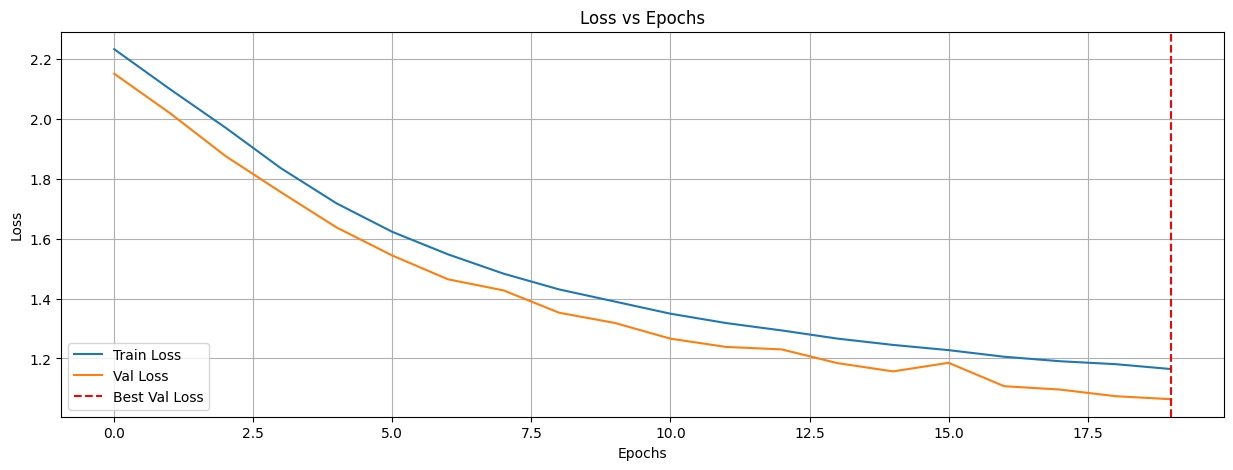

In [23]:
#epoch of best validation loss
print(f"Best validation loss: {best_loss:.4f}")
index_best = losses_val.index(best_loss)

plt.figure(figsize=(15, 5))
plt.plot(losses, label="Train Loss")
plt.plot(losses_val, label="Val Loss")
plt.axvline(index_best, color='r', linestyle='--', label="Best Val Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

**Below there is the evaluation of the gold model**

In [24]:
# load weights gold model
gold_model = create_model()
gold_model.load_state_dict(torch.load("./checkpoint/gold_model.pth"))
gold_model.eval()
gold_model.to(device);

# print accuracies on retain, forget and test set
retain_accuracy = accuracy(gold_model, retain_loader)
forget_accuracy = accuracy(gold_model, forget_loader)
test_accuracy = accuracy(gold_model, test_loader)
test_accuracy_retain = accuracy(gold_model, retain_loader_test)
test_accuracy_forget = accuracy(gold_model, forget_loader_test)

print(f"Retain set Accuracy: {100* retain_accuracy:.4f}")
print(f"Forget set Accuracy: {100* forget_accuracy:.4f}")
print(f"Test set Accuracy: {100* test_accuracy:.4f}")
print(f"Test set Retain Accuracy: {100* test_accuracy_retain:.4f}")
print(f"Test set Forget Accuracy: {100* test_accuracy_forget:.4f}")

C:\Users\Livia_99\AppData\Local\Temp\ipykernel_2272\1013974794.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gold_model.load_state_dict(torch.load("./checkpoint/gold_m

Retain set Accuracy: 61.1933
Forget set Accuracy: 0.0000
Test set Accuracy: 54.1500
Test set Retain Accuracy: 60.1667
Test set Forget Accuracy: 0.0000


#### Your Turn

**Question**

Q: *Explain the results of the Gold Model. Did you notice something strange?*

A: <br>
We can observe from the graph that the training and validation loss curves both decrease consistently across epochs. However, an unusual aspect is that the validation loss curve runs parallel to the training loss for most of the training but remains slightly higher until the very end.

This behavior is usually attributed to:

- **Regularization Effects**: Regularization techniques (e.g., dropout, batch normalization, weight decay) apply noise or constraints during training to prevent overfitting. These techniques make the training process noisier, increasing the training loss compared to the validation loss (where such noise is not applied).

- **Validation Set is "Easier" Than the Training Set**: If the validation set is simpler, less noisy, or more balanced compared to the training set, the model may achieve lower validation loss than training loss, especially early in training.

- **Early Training Dynamics**: During the initial stages of training, the model's weights may not fully capture the complexity of the training data but can generalize better to the simpler validation set. This difference often resolves as training progresses and the model fits the training data more effectively.

- **Data Leakage Between Training and Validation**: If there is overlap between the training and validation data, the model may effectively memorize validation samples, leading to validation loss being lower than training loss.

Among these, the most likely explanations are that the validation set is easier than the training set due to differences in noise, complexity, or preprocessing steps, or that the behavior reflects early training dynamics where the model generalizes better to simpler validation data.

Another potentially "strange" result is that while the model successfully achieves the goal of forgetting specific data with a forget accuracy of 0.0%, the overall test accuracy (54%) is quite close to the retain accuracy (61%). Ideally, some drop in test accuracy would be expected due to unlearning effects, as unlearning typically reduces the model's general capacity to retain information.

This particular behavior might indicate that the model has overfit the retained dataset during unlearning, neglecting the general structure of the forget data, or that the model struggles to generalize beyond the retained dataset after unlearning, possibly due to an imbalance in the optimization process.

# Section 4: Mia attacks

In this section, we'll quantify the quality of the unlearning algorithm through a simple membership inference attack (MIA).
MIAs are a type of adversarial attack aimed at determining whether a specific data point was included in the training dataset of a machine learning model. These attacks exploit the behavior of the model to make inferences about the presence or absence of certain data points.
This MIA consists of a logistic regression model that predicts whether the model was trained on a particular sample from that sample's loss.



In [25]:
def compute_losses(model, loader, criterion = "CrossEntropy"):

    """
    Auxiliary function to compute per-sample losses
    Args:
    model : model to evaluate
    loader : data loader
    criterion : loss function. Specify "CrossEntropy" for cross-entropy loss or "KL" for KL divergence
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        logits = model(inputs)
        losses = nn.CrossEntropyLoss(reduction = "none")(logits, targets).detach().cpu().numpy()

        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


In [26]:
#model
model = create_model()
model.load_state_dict(torch.load("./checkpoint/best_model.pth", map_location=torch.device('cpu'))); #because of cpu usage
model.eval()
model.to(device);

retain_losses = compute_losses(model, retain_loader_test)
forget_losses = compute_losses(model, forget_loader_test)


C:\Users\Livia_99\AppData\Local\Temp\ipykernel_2272\2798354586.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./checkpoint/best_model.

In [27]:
# forget model
forget_model = create_model()
forget_model.load_state_dict(torch.load("./checkpoint/forget_model.pth", map_location=torch.device('cpu'))); #because of cpu usage
forget_model.eval()
forget_model.to(device);

retain_losses_forget = compute_losses(forget_model, retain_loader_test)
forget_losses_forget = compute_losses(forget_model, forget_loader_test)


C:\Users\Livia_99\AppData\Local\Temp\ipykernel_2272\2535967232.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  forget_model.load_state_dict(torch.load("./checkpoint/forg

In [28]:
# gold model
gold_model = create_model()
gold_model.load_state_dict(torch.load("./checkpoint/gold_model.pth", map_location=torch.device('cpu'))); #because of cpu usage
gold_model.eval()
gold_model.to(device);

retain_losses_gold = compute_losses(gold_model, retain_loader_test)
forget_losses_gold = compute_losses(gold_model, forget_loader_test)

C:\Users\Livia_99\AppData\Local\Temp\ipykernel_2272\3740578339.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gold_model.load_state_dict(torch.load("./checkpoint/gold_m

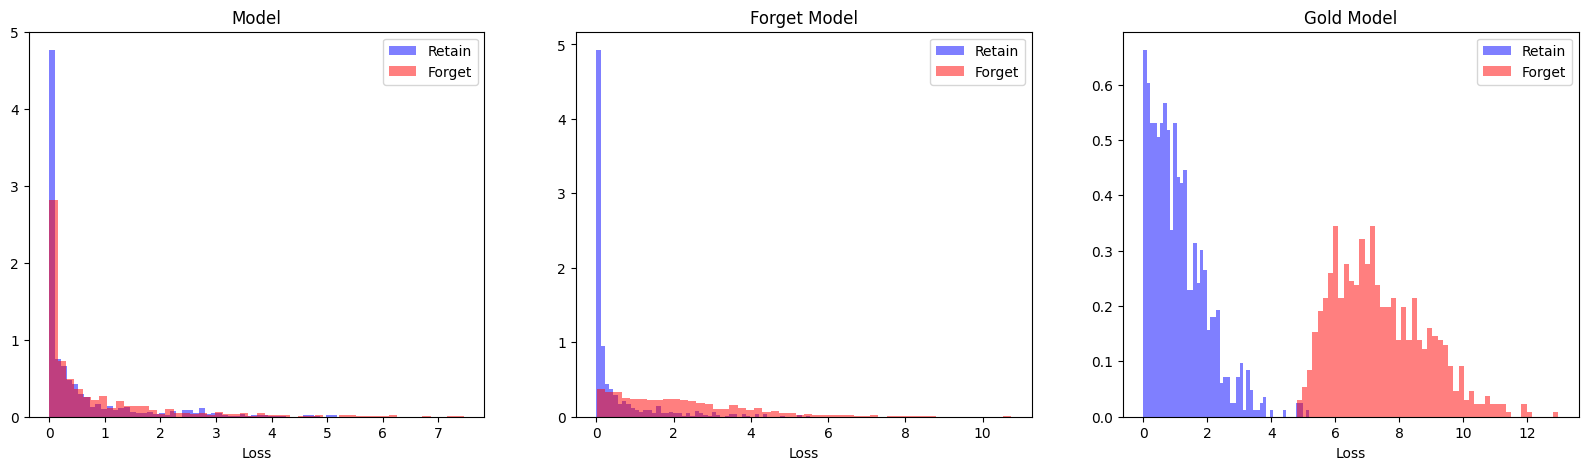

In [29]:
# 3 plots woth ax of histograms
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

#subsample retrain losses to have the same size as the forget losses
random_idx = np.random.choice(np.arange(len(retain_losses)), len(forget_losses), replace=False)
retain_losses = retain_losses[random_idx]
retain_losses_forget = retain_losses_forget[random_idx]
retain_losses_gold = retain_losses_gold[random_idx]


axs[0].hist(retain_losses, density = True, bins=50, alpha=0.5, label='Retain', color='blue')
axs[0].hist(forget_losses, density = True, bins=50, alpha=0.5, label='Forget', color='red')
axs[0].set_title('Model')
axs[0].set_xlabel('Loss')
axs[0].legend()

axs[1].hist(retain_losses_forget, density = True, bins=50, alpha=0.5, label='Retain', color='blue')
axs[1].hist(forget_losses_forget, density = True, bins=50, alpha=0.5, label='Forget', color='red')
axs[1].set_title('Forget Model')
axs[1].set_xlabel('Loss')
axs[1].legend()

axs[2].hist(retain_losses_gold, density = True, bins=50, alpha=0.5, label='Retain', color='blue')
axs[2].hist(forget_losses_gold, density = True, bins=50, alpha=0.5, label='Forget', color='red')
axs[2].set_title('Gold Model')
axs[2].set_xlabel('Loss')
axs[2].legend()

plt.show()

In [30]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    torch.manual_seed(torch.initial_seed())

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression(random_state=random_state)
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state = 0
    )

    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy",
    )

In [31]:
# mia on model
retain_losses_subsample = np.random.choice(retain_losses, len(forget_losses), replace=False)
samples_mia = np.concatenate([retain_losses_subsample, forget_losses]).reshape(-1, 1)
#balance the number of samples
members_mia = np.concatenate([np.zeros(len(retain_losses_subsample)), np.ones(len(forget_losses))])

scores_model = simple_mia(samples_mia, members_mia)
print(f"Model MIA score: {scores_model.mean():.4f}")

Model MIA score: 0.5369


In [32]:
#mia on forget model
retain_losses_forget_subsample = np.random.choice(retain_losses_forget, len(forget_losses_forget), replace=False)
samples_mia = np.concatenate([retain_losses_forget_subsample, forget_losses_forget]).reshape(-1, 1)
members_mia = np.concatenate([np.zeros(len(retain_losses_forget_subsample)), np.ones(len(forget_losses_forget))])

scores_forget = simple_mia(samples_mia, members_mia)
print(f"Forget Model MIA score: {scores_forget.mean():.4f}")

Forget Model MIA score: 0.7563


In [33]:
# mia on gold model
retain_losses_gold_subsample = np.random.choice(retain_losses_gold, len(forget_losses_gold), replace=False)
samples_mia = np.concatenate([retain_losses_gold_subsample, forget_losses_gold]).reshape(-1, 1)
members_mia = np.concatenate([np.zeros(len(retain_losses_gold_subsample)), np.ones(len(forget_losses_gold))])

scores_gold = simple_mia(samples_mia, members_mia)
print(f"Gold Model MIA score: {scores_gold.mean():.4f}")

Gold Model MIA score: 0.9975


#### Your Turn ( 3 Points)

**Question**

Q: *For each model, analyze the loss plots and explain the results obtained from the membership inference attack (MIA).*

A: <br>

By comparing the 3 models we can observe 3 different cases:
1. For the **Original Model** loss plot, the distributions of losses for retain and forget samples are nearly overlapping, that indicates that the original model has similar confidence in its predictions for both retain and forget samples, as it was trained on both sets.<br>
The MIA score of around **`0.54`** is close to random guessing (0.5), indicating that the logistic regression attack model cannot reliably distinguish between retain and forget samples based on loss alone.This low score reflects the lack of separation in the loss values between retain and forget samples, meaning the original model treats them similarly.<br>
Since the model was trained on both retain and forget samples, it has effectively “memorized” both types, leading to similar loss values and making membership inference difficult. An expected result, as there is no unlearning applied in this model.

2. In the **Forget Model** loss plot it can be observed more separation between the retain and forget loss distributions compared to the original model.
Retain samples still have a low loss peak near zero, indicating the model retains knowledge of these samples.
Forget samples, however, show a broader loss distribution with generally higher values, suggesting that the forget model is less confident on forget samples, a sign of effective unlearning.<br>
The MIA score for the forget model is much higher than the original model one, at **`0.78`**. This indicates that the MIA attack can differentiate between retain and forget samples with reasonable accuracy, based on the higher losses on forget samples.
The score reflects partial success in unlearning, as there is a noticeable difference in loss behavior between retain and forget samples.<br>
The increased loss on forget samples suggests that the forget model has successfully reduced its confidence on these samples, which is desirable in unlearning. However, the fact that the MIA score is not close to 1.0 suggests that some information about the forget samples may still remain, and the unlearning process is not as effective as it could be.

3. For the **Gold Model** the loss plot shows a clear separation between retain and forget samples. Retain samples have a low loss distribution (similar to the retain samples in the forget and original models), indicating high confidence in predicting these samples correctly.
Forget samples, however, exhibit a much broader and higher loss distribution compared to the retain samples, indicating that the model has no knowledge of these samples and is not confident in predicting them.<br>
The MIA score for the gold model is extremely high, nearly 1.0, indicating almost perfect accuracy in distinguishing between retain and forget samples.
This high score reflects the ideal unlearning scenario, where the model has no memory of forget samples, resulting in significantly higher losses on forget samples.<br>
The gold model represents an ideal unlearning case where there is a clear distinction between retain and forget samples.
This high MIA score sets the benchmark, showing that the forget model should ideally achieve a similar level of separation to be considered highly effective at unlearning.


In summary, the ***gold model*** demonstrates the most effective unlearning, as evidenced by its clear distinction between retain and forget samples and near-perfect MIA score. In contrast, the ***original model***, which does not employ unlearning, shows little to no separation in loss values for retain and forget samples, resulting in an MIA score close to random guessing. The ***forget model*** shows partial success in unlearning, with a moderate level of separation and a respectable MIA score of **`0.78`**. However, it does not fully achieve the effectiveness of the gold model, indicating that some residual information about the forget samples remains.

# 5. Unlearning with Kl divergence


The Kullback-Leibler (KL) divergence is a measure of how one probability distribution differs from another. In this case, to induce unlearning, we want the model's predictions on the forget set to match a uniform distribution, meaning the model "forgets" any specific information about these classes.

#### Your Turn (1 Point)

Next, consider a simple scenario to clarify the concept: a classification problem with four classes. Here, the objective is to unlearn one class by enforcing the logits' distribution (after the softmax) to match a uniform distribution. In this case, let the target distribution for a sample coming from the forget set be $y_{gt} = [0.25, 0.25, 0.25, 0.25]$, and assume that you have achieved the predicted distribution $y_{pred} = [0.25, 0.25, 0.25, 0.25]$

**Question**

Q: *In this context, why is it preferable to use KL divergence instead of Cross-Entropy? Explain it and fill the code below in order to show it numerically.*

A: <br>

In this context, **KL divergence** is preferable to **cross-entropy** because KL divergence directly measures the "distance" between the predicted distribution $y_{pred}$ and the target uniform distribution $y_{gt}$.

The KL divergence, defined by

$$
D_{KL}(P \parallel Q) = \sum_{x \in \mathcal{X}} P(x) \log \left( \frac{P(x)}{Q(x)} \right) \quad \text{[1]},
$$

quantifies how much the predicted distribution $y_{pred}$ deviates from the desired uniform target $y_{gt}$.<br>

On the other hand, **cross-entropy** is typically used to compare predicted probabilities with one-hot encoded true labels in classification tasks, and it is given by:

1. For *discrete probability distributions*
$$
H(P, Q) = - \sum_{x \in \mathcal{X}} P(x) \log Q(x). \quad \text{[2a]}
$$

2. For *continuous probability distributions*
$$
H(P, Q) = - \int_{x} P(x) \log Q(x) \, dx. \quad \text{[2b]}
$$

In summary, KL divergence is ideal here because it directly measures divergence from the uniform target distribution, while cross-entropy is better suited for comparing predicted probabilities with true class labels.<br>
[[1]](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)
[[2]](https://en.wikipedia.org/wiki/Cross-entropy)

In [34]:
y_gt = torch.tensor([0.25, 0.25, 0.25, 0.25])
y_pred = torch.tensor([0.25, 0.25, 0.25, 0.25])

'''
Add your code below
'''
cross_entropy =  -torch.sum(y_gt * torch.log(y_pred))
kl_div = torch.sum(y_gt * (torch.log(y_gt) - torch.log(y_pred)))

print(f"Cross Entropy: {cross_entropy:.4f}")
print(f"KL Divergence: {kl_div:.4f}")

Cross Entropy: 1.3863
KL Divergence: 0.0000


**Question**

Q: *Before proceeding, you should explain the relationship between Cross-Entropy and Kullback-Leibler (KL) divergence. Provide the proof showing how to derive the relationship between the two.*

A: <br>


Focusing on the discrete probabilty distribution for the proof we start from the KL Divergence definition: <br>
$$
D_{KL}(P \parallel Q) = \sum_{x \in \mathcal{X}} P(x) \log \left( \frac{P(x)}{Q(x)} \right) =
$$

Applying logartimic properties:

$$
= \sum_{x \in \mathcal{X}} P(x) (\log({P(x)})-log({Q(x)})) =
$$

$$
=\sum_{x \in \mathcal{X}} P(x) (\log{P(x)}) - \sum_{x \in \mathcal{X}} P(x) (\log{Q(x)}) =
$$

Expanding the KL divergence:

$$
D_{KL}(P \parallel Q) =\sum_{x \in \mathcal{X}} P(x) (\log{P(x)}) - \sum_{x \in \mathcal{X}} P(x) (\log{Q(x)})
$$

$$
D_{KL}(P \parallel Q) -\sum_{x \in \mathcal{X}} P(x) (\log{P(x)}) = - \sum_{x \in \mathcal{X}} P(x) (\log{Q(x)})
$$

Rearranging to Derive Cross-Entropy Formula:

$$
H(P, Q) = D_{KL}(P \parallel Q) + H(P)
$$


In summary, this derivation shows that cross-entropy $H(P, Q)$ can be understood as the sum of the KL divergence $D_{KL}(P \parallel Q)$, which measures the "extra cost" due to the difference between $P$ and $Q$, and the entropy $H(P)$, which represents the inherent uncertainty in $P$.


In [35]:
#fix seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [36]:
def make_target (target, number_of_classes = 10):
    '''
    Function to modify the target class
    '''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tensor = torch.nn.functional.one_hot(target, num_classes= number_of_classes ).float().to(device)
    # Identify rows with 1 in the first position
    first_pos_mask = target == 0

    # Substite the rows with 1 in the first position with a uniform distribution
    n = tensor.size(1)  # Numero di colonne
    uniform_distribution = torch.full((n,), 1.0 / n, device = device)  # Distribuzione uniforme
    tensor[first_pos_mask] = uniform_distribution

    return tensor

In [37]:
def unlearning_2 (model, forget_loader, validation, epochs, optimizer, scheduler):
    '''
    Function to unlearn the forget set
    '''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    epsilon = 1e-5
    model.to(device)
    losses = []
    losses_val = []

    for epoch in range(epochs):
        model.train()
        loss_epoch = 0
        loop = tqdm(enumerate(forget_loader), total=len(forget_loader), leave=True)
        for batch_idx, (inputs, targets) in loop:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs + epsilon
            outputs = F.log_softmax(outputs, dim=1)

            targets = make_target(targets)
            loss = F.kl_div(outputs, targets, reduction='batchmean')
            loss.backward()
            optimizer.step()

            #running loss
            loss_epoch += loss.item()
            # Update progress bar with loss and epoch information
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item())

        #avg loss
        avg_loss = loss_epoch / len(forget_loader )
        losses.append(avg_loss)
        #scheduler step
        scheduler.step(avg_loss)
        tqdm.write(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}")

        # validation
        loss_val = 0
        model.eval()
        with torch.no_grad():
            for data, targets in validation:
                data = data.to(device=device)
                targets = targets.to(device=device)

                scores = model(data)
                scores = scores + epsilon
                scores = F.log_softmax(scores, dim=1)
                targets = make_target(targets)
                loss = F.kl_div(scores, targets, reduction='batchmean')
                loss_val += loss.item()
            # Calculate average loss for the epoch
            avg_val_loss = loss_val / len(validation)
            losses_val.append(avg_val_loss)
            print(f"Validation Loss: {avg_val_loss:.4f}")
            # if avg val_loss is better than the one before, save the model
            if epoch == 0:
                # create directory if not exist
                os.makedirs("checkpoint", exist_ok=True)
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "./checkpoint/another_forget_model.pth")
            elif avg_val_loss < best_loss:
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "./checkpoint/another_forget_model.pth")
    return model, losses, losses_val

In [38]:
another_forget_model = create_model()
another_forget_model.load_state_dict(torch.load("./checkpoint/best_model.pth", map_location=torch.device('cpu'))); #because of cpu usage
another_forget_model.to(device);

# optimizer
optimizer = torch.optim.Adam(another_forget_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 10

forget_loader = forget_loader
val_loader = forget_loader_val

another_forget_model, losses, losses_val = unlearning_2(another_forget_model, forget_loader, val_loader, num_epochs, optimizer, scheduler)

C:\Users\Livia_99\AppData\Local\Temp\ipykernel_2272\1731935167.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  another_forget_model.load_state_dict(torch.load("./checkpo

Epoch [1/10], Average Loss: 1.6618
Validation Loss: 1.4846


Epoch [2/10]: 100%|██████████| 10/10 [00:02<00:00,  3.76it/s, loss=1.1]


Epoch [2/10], Average Loss: 1.3002
Validation Loss: 1.0868


Epoch [3/10]: 100%|██████████| 10/10 [00:02<00:00,  3.75it/s, loss=0.929]


Epoch [3/10], Average Loss: 1.0484
Validation Loss: 0.8545


Epoch [4/10]: 100%|██████████| 10/10 [00:02<00:00,  3.87it/s, loss=0.82]


Epoch [4/10], Average Loss: 0.8762
Validation Loss: 0.7137


Epoch [5/10]: 100%|██████████| 10/10 [00:02<00:00,  4.12it/s, loss=0.717]


Epoch [5/10], Average Loss: 0.7533
Validation Loss: 0.6219


Epoch [6/10]: 100%|██████████| 10/10 [00:02<00:00,  3.99it/s, loss=0.602]


Epoch [6/10], Average Loss: 0.6527
Validation Loss: 0.5461


Epoch [7/10]: 100%|██████████| 10/10 [00:02<00:00,  4.07it/s, loss=0.499]


Epoch [7/10], Average Loss: 0.5694
Validation Loss: 0.4773


Epoch [8/10]: 100%|██████████| 10/10 [00:02<00:00,  4.06it/s, loss=0.489]


Epoch [8/10], Average Loss: 0.5101
Validation Loss: 0.4246


Epoch [9/10]: 100%|██████████| 10/10 [00:02<00:00,  4.08it/s, loss=0.411]


Epoch [9/10], Average Loss: 0.4550
Validation Loss: 0.3817


Epoch [10/10]: 100%|██████████| 10/10 [00:02<00:00,  4.08it/s, loss=0.382]

Epoch [10/10], Average Loss: 0.4107
Validation Loss: 0.3451


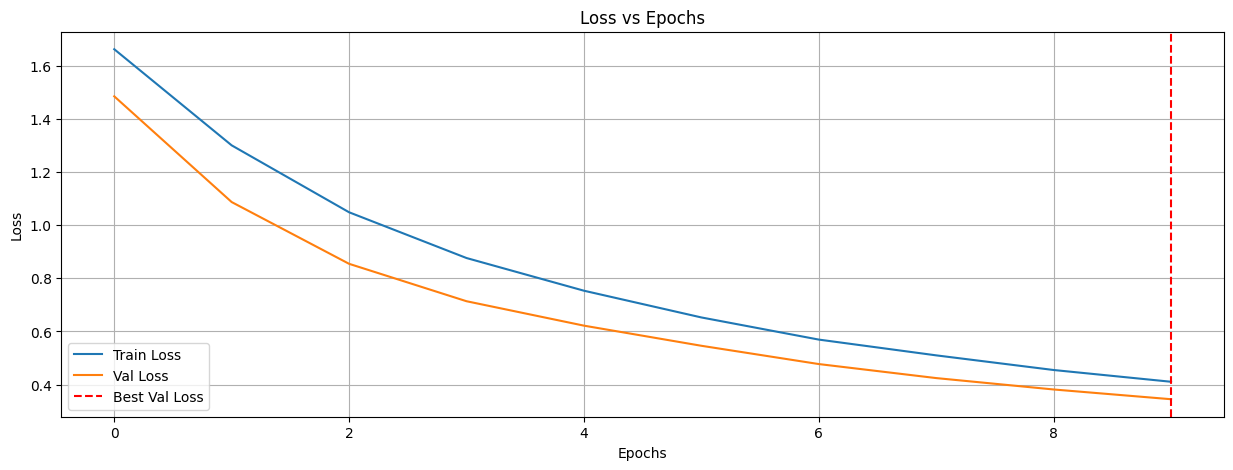

In [39]:
#plot losses
#epoch of best validation loss
index_best = losses_val.index(min(losses_val))

plt.figure(figsize=(15, 5))
plt.plot(losses, label="Train Loss")
plt.plot(losses_val, label="Val Loss")
plt.axvline(index_best, color='r', linestyle='--', label="Best Val Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [40]:
# calculate accuracy
another_forget_model = create_model()
another_forget_model.load_state_dict(torch.load("./checkpoint/another_forget_model.pth", map_location=torch.device('cpu'))) #because of cpu usage
another_forget_model.eval()
another_forget_model.to(device)


# Calculate the accuracy on the test set
retain_accuracy = accuracy(another_forget_model, retain_loader)
forget_accuracy = accuracy(another_forget_model, forget_loader)
test_accuracy = accuracy(another_forget_model, test_loader)
retain_test_accuracy = accuracy(another_forget_model, retain_loader_test)
forget_test_accuracy = accuracy(another_forget_model, forget_loader_test)

C:\Users\Livia_99\AppData\Local\Temp\ipykernel_2272\2561108106.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  another_forget_model.load_state_dict(torch.load("./checkpo

In [41]:
# print accuracies on retain, forget and test set
print(f"Retain Accuracy: {100* retain_accuracy:.4f}")
print(f"Forget Accuracy: {100* forget_accuracy:.4f}")
print(f"Test Accuracy: {100* test_accuracy:.4f}")
print(f"Test Retain Accuracy: {100* retain_test_accuracy:.4f}")
print(f"Test Forget Accuracy: {100* forget_test_accuracy:.4f}")

Retain Accuracy: 64.0733
Forget Accuracy: 16.5000
Test Accuracy: 56.5125
Test Retain Accuracy: 61.1667
Test Forget Accuracy: 14.6250


In [42]:
# calculate losses of the model on forget and retain test set
retain_losses_CE = compute_losses(another_forget_model, retain_loader_test)
forget_losses_CE = compute_losses(another_forget_model, forget_loader_test)

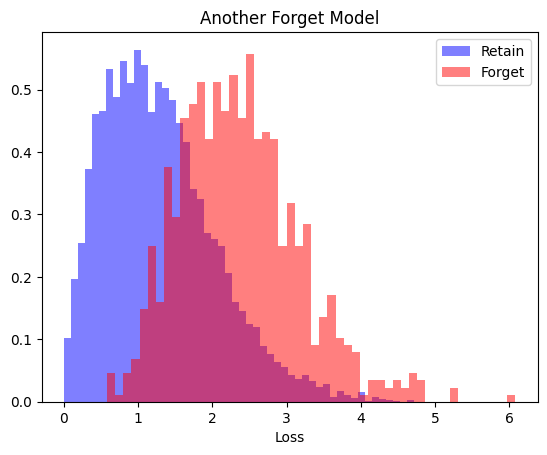

In [43]:
plt.hist(retain_losses_CE, density = True, bins=50, alpha=0.5, label='Retain', color='blue')
plt.hist(forget_losses_CE, density = True, bins=50, alpha=0.5, label='Forget', color='red')
plt.title('Another Forget Model')
plt.xlabel('Loss')
plt.legend()
plt.show()

In [44]:
# mia attack on cross entropy
np.random.seed(0)
subsample_retain_losses_CE = np.random.choice(retain_losses_CE, len(forget_losses), replace=False)
samples_mia = np.concatenate([subsample_retain_losses_CE, forget_losses_CE]).reshape(-1, 1)
members_mia = np.concatenate([np.zeros(len(subsample_retain_losses_CE)), np.ones(len(forget_losses))])

scores_another_forget = simple_mia(samples_mia, members_mia)
print(f"Another Forget Model MIA score with Cross Entropy losses: {scores_another_forget.mean():.4f}")

Another Forget Model MIA score with Cross Entropy losses: 0.7675


This is another way of performing unlearning, you may have noticed that the distributions of the retain and forget sets are different but still there is an overlapping portion. It is very likely that the MIA attack will fail in that specific region.

# 6. GMN for unlearning (6 Points)

Now, we will attempt to use the GMN you have implemented in the theory notebook for the unlearning task. Keep in mind that this is a novel and challenging task, and it is quite possible that the results may not meet your expectations. However, this is the nature of research. Therefore, the evaluation will focus on the clarity of your approach and your ability to justify your choices and results, rather then the result itself.

First of all, go into the ```Practice/gmn/graph_models.py``` file and replace the empty classes with what you have implemented in the second part of the theory notebook. Then, try to think about and implement an unlearning algorithm that leverages the graph metanetwork, and evaluate the unlearned model with MIA attacks and accuracy scores. It would be super cool to have a neural network (the GMN) that can take as input other pretrained neural networks and produce as output the same networks but unlearned over a specific subset of data samples.

In the end, generate a detailed report where you describe your idea, methodology and implementation. Put the most of your effort in explaining us the ideas and the intuitions that you had, since this is what we will reward. Don't be worried if results are poor, there can be many causes of this and it's not your task to solve all of them.

#### **THE REPORT IS IN A PDF DOCUMENT ATTACHED TO THE EMAIL**

In [45]:
%pip install torch_scatter -f https://data.pyg.org/whl/torch-2.5.1+cpu.html
%pip install opt_einsum


Looking in links: https://data.pyg.org/whl/torch-2.5.1+cpu.html
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\Livia_99\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\Livia_99\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [46]:
from torch_geometric.loader import DataLoader

In [47]:
from gmn.graph_models import *
from torch_geometric.data import Data, Batch
from gmn.graph_construct.model_arch_graph import sequential_to_arch, arch_to_graph, graph_to_arch, arch_to_sequential
from gmn.feature_extractor_gmn import NodeEdgeFeatEncoder
from gmn.graph_models import MPNN

torch.manual_seed(0)

weights = torch.load("./checkpoint/best_model.pth", map_location=torch.device('cpu')) #for cpu usage
model = create_model()
model.load_state_dict(weights)
arch = sequential_to_arch(model)
x, edge_index, edge_attr = arch_to_graph(arch)
x = x.float()
edge_attr = edge_attr.float()

# currently u is a vector of zeros, and it is basically useless. You can consider filling it with what you prefer and leverage it for the task of unlearning
g_cnn = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, u = torch.zeros(1, 8))

graph_batch = Batch.from_data_list([g_cnn])
print(graph_batch)

DataBatch(x=[216, 3], edge_index=[2, 59050], edge_attr=[59050, 6], u=[1, 8], batch=[216], ptr=[2])


C:\Users\Livia_99\AppData\Local\Temp\ipykernel_2272\3314917291.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load("./checkpoint/best_model.pth", map_lo

In [48]:
class GraphMetaNetwork(nn.Module):
    '''
    Wrapper class for the graph metanetwork
    '''
    def __init__(self, encoder, mpnn):
        super(GraphMetaNetwork, self).__init__()
        self.encoder = encoder
        self.mpnn = mpnn

    def forward(self, data):
        x, edge_index, edge_attr, u, batch = data.x, data.edge_index, data.edge_attr, data.u, data.batch
        x, edge_attr = self.encoder(x, edge_attr)
        x, edge_attr, u = self.mpnn(x, edge_index, edge_attr, u, batch)
        return edge_attr

# Define the encoder and MPNN
pre_embedding_dim = 64
global_in_dim = 8
hidden_dim = 32
node_out_dim = 3
edge_out_dim = 1
global_out_dim = 8
num_gnn_layers = 4
encoder = NodeEdgeFeatEncoder(hidden_dim=pre_embedding_dim)
mpnn = MPNN(node_in_dim=pre_embedding_dim,
            edge_in_dim=pre_embedding_dim,
            global_in_dim = global_in_dim,
            hidden_dim=hidden_dim,
            node_out_dim= node_out_dim,
            edge_out_dim = edge_out_dim,
            global_out_dim= global_out_dim,
            num_layers=num_gnn_layers,
            reduce='mean')

# Create the metanetwork
gmn = GraphMetaNetwork(encoder, mpnn)
gmn.to(device)

GraphMetaNetwork(
  (encoder): NodeEdgeFeatEncoder(
    (node_layer_encoder): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Sin()
    )
    (neuron_num_encoder): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Sin()
    )
    (node_type_encoder): Embedding(17, 64)
    (x_proj): Linear(in_features=192, out_features=64, bias=True)
    (weight_encoder): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Sin()
    )
    (edge_layer_encoder): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Sin()
    )
    (conv_pos_encoder): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): Sin()
    )
    (edge_type_encoder): Embedding(14, 64)
    (edge_attr_proj): Linear(in_features=256, out_features=64, bias=True)
  )
  (mpnn): MPNN(
    (convs): ModuleList(
      (0): MetaLayer(
        edge_model=EdgeModel(
        (edge_mlp): S

If you need to convert the output of the gmn back into a neural network model (i.e., an ```nn.Sequential``` object), please look into ```graph_to_arch``` and ```arch_to_sequential``` functions stored in ```Practice/gmn/graph_construct/model_arch_graph.py```.

### **Dataset introduction**

For this task, we used the ***Cora dataset***. The dataset is a citation network, where nodes represent scientific papers, and edges indicate citation relationships between them. Each node is associated with a **bag-of-words vector** derived from the paper's content, and the dataset includes **7 classes**, representing different research topics (e.g., Neural Networks, Rule Learning).

Key characteristics of the Cora dataset include:
- **Nodes**: 2708 scientific papers.
- **Edges**: 10556 connections.
- **Features**: 1433 unique words used to describe the papers.
- **Classes**: 7 research topics, imbalanced in distribution.

*Further details about the dataset are detailed in the report* [[dataset reference]](https://medium.com/@koki_noda/ultimate-guide-to-graph-neural-networks-1-cora-dataset-37338c04fe6f).



In [ ]:
#Importing the dataset
from torch_geometric.datasets import Planetoid

#Loading the dataset
dataset = Planetoid(root='data', name='Cora')

#Extracting the graph
data = dataset[0]

print(f"Dataset: {dataset}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of features: {data.num_features}")
print(f"Number of classes: {dataset.num_classes}")

Dataset: Cora()
Number of nodes: 2708
Number of edges: 10556
Number of features: 1433
Number of classes: 7


In [50]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='/tmp/Cora', name='Cora')

Cora dataset is already splitted in train, test and validation:

In [ ]:
#Training, validation, and test 
train_mask = dataset.train_mask
val_mask = dataset.val_mask
test_mask = dataset.test_mask

print(f"Training nodes: {train_mask.sum().item()}")
print(f"Validation nodes: {val_mask.sum().item()}")
print(f"Testing nodes: {test_mask.sum().item()}")

Training nodes: 140
Validation nodes: 500
Testing nodes: 1000


After loading the dataset and exploring it a bit we decided ***what to use the `vector u` for***.
Since we are working with a specific class ("Neural Network" topic) we can use u to encode this information with one-hot-encoded labels.<br>

This ensures that every graph already has its u vector filled with a one-hot encoding of the class label. Therefore, we don’t need to redefine or explicitly pass the u vector into the unlearning function. Instead, the u vector for each graph is embedded in the Data object (data.u) and can be accessed directly during the unlearning process.

***Integrate the Pre-trained Graph with the Cora Dataset***<br>

We decided to Integrate the Pre-trained Graph with the Cora Dataset to take advantage of the knowledge already captured by the pre-trained model. This helps the model better understand the relationships in the citation network, making the learning and unlearning processes more effective.

Before proceeding further let's check if the input dimension of the graph we want to integrate alligns with the pre-trained GMN, otherwise ww will need to modify the encoder:

In [52]:
cora_input_dim = dataset.num_node_features
print(f"Cora input dimension:{cora_input_dim}")
print(f"Pre-trained GMN input dimension: {pre_embedding_dim}")

Cora input dimension:1433
Pre-trained GMN input dimension: 64


> The input dimension of the Cora graph and the Pre-trained DMN are effectively different, so we will need to modify the encoder, but we can do it later and now integrate the Cora dataset and the Pre-trained GMN:

In [ ]:
#Use Cora features and labels for the g_cnn, the graph-based output of the pre-trined network
g_cnn.x = data.x  #Cora's node features
g_cnn.y = data.y  #Cora's labels
g_cnn.edge_index = data.edge_index  #Cora's edges

#Initialize u as a one-hot vector to indicate the "forget" class
g_cnn.u = torch.zeros(1, dataset.num_classes)
forget_class_idx = 0  #we want to forget class 1 (indexed at 0)
g_cnn.u[0, forget_class_idx] = 1.0  #Set the forget class 

#Let's print the u vector to check it
print(f"Global vector `u`: {g_cnn.u}")

Global vector `u`: tensor([[1., 0., 0., 0., 0., 0., 0.]])


Now we can define a subclass of the `GraphMetaNetwork` that incorporates the necessary methods to implement unlearning.<br> This subclass extends the original architecture by adding mechanisms to compute influence, adjust the loss function, and guide the optimization process for effective forgetting of specific classes (influence-based loss adjustement and L2 regularization, detailed in the report):

In [ ]:
class GraphMetaNetworkWithUnlearn(GraphMetaNetwork):
    """
    Wrapper class for the graph meta network, with unlearning capabilities.
    """

    def __init__(self, encoder, mpnn):
        super(GraphMetaNetworkWithUnlearn, self).__init__(encoder, mpnn)
        self.encoder = encoder
        self.mpnn = mpnn

    def forward(self, data):
        """
        Forward pass incorporating the global vector `u`.
        """
        x, edge_index, edge_attr, u, batch = (
            data.x,
            data.edge_index,
            data.edge_attr,
            data.u,
            data.batch,
        )
        x, edge_attr = self.encoder(x, edge_attr)
        x, edge_attr, u = self.mpnn(x, edge_index, edge_attr, u, batch)
        return edge_attr, u

    def compute_influence(self, data, criterion):
        """
        Compute gradients of the loss with respect to the model's parameters for the given data.
        Args:
          data: Data object containing the sample(s) to compute influence.
          criterion: Loss function used for influence computation.

        Returns:
          influence_gradients: Dictionary of parameter gradients.
        """
        self.eval() 
        data = data.to(next(self.parameters()).device)
        outputs, _ = self(data)  #Incorporate the vector in the forward pass
        loss = criterion(outputs, data.y)
        self.zero_grad()
        loss.backward()

        influence_gradients = {
            name: param.grad.clone().detach()
            for name, param in self.named_parameters()
            if param.grad is not None
        }
        return influence_gradients

    def compute_forget_loss(self, u, forget_class_idx):
        """
        Compute a penalty based on the global vector `u` to guide unlearning.
        Args:
            u: Global vector indicating the forget class.
            forget_class_idx: Index of the forget class in `u`.
        Returns:
            Penalty term for the loss.
        """
        forget_signal = u[:, forget_class_idx]
        return torch.mean(forget_signal)

    def unlearn(self, retain_loader, validation_loader, epochs=5, criterion=None, optimizer=None, forget_class_idx=None):
        """
        Unlearn method with influence-based loss adjustment.

        Args:
            retain_loader: DataLoader with retained data.
            validation_loader: DataLoader for validation set.
            epochs: Number of epochs to unlearn.
            criterion: Loss function.
            optimizer: Optimizer for gradient descent.
            forget_class_idx: Index of the class to forget, indicated in `u`.

        Returns:
            losses: Training losses per epoch.
            losses_val: Validation losses per epoch.
        """
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        losses = []
        losses_val = []

        #Compute influence gradients for the forget class
        print("Computing influence for the forget class...")
        self.eval()
        influence_gradients = None
        for data in retain_loader:
            data = data.to(device)
            if data.u[0, forget_class_idx] == 1.0:  #Use the vector u to select forget class
                grads = self.compute_influence(data, criterion)
                if influence_gradients is None:
                    influence_gradients = grads
                else:
                    for name in grads:
                        influence_gradients[name] += grads[name]

        if influence_gradients:
            for name in influence_gradients:
                influence_gradients[name] /= len(retain_loader)
        print("Influence gradients computed.")

        #Unlearning 
        for epoch in range(epochs):
            self.train()
            loss_epoch = 0
            for batch_idx, data in enumerate(retain_loader):
                data = data.to(device)

                optimizer.zero_grad()
                outputs, u = self(data)
                loss = criterion(outputs, data.y)

                #Adjust the loss using influence gradients for the forget class
                for name, param in self.named_parameters():
                    if name in influence_gradients:
                        loss += 0.01 * torch.norm(param.grad - influence_gradients[name])

                #Incorporate forget-specific penalty
                loss += self.compute_forget_loss(u, forget_class_idx)

                loss.backward()
                optimizer.step()
                loss_epoch += loss.item()

            avg_loss = loss_epoch / len(retain_loader)
            losses.append(avg_loss)

            #Validation loss
            self.eval()
            loss_val = 0
            with torch.no_grad():
                for data in validation_loader:
                    data = data.to(device)
                    outputs, _ = self(data)
                    loss_val += criterion(outputs, data.y).item()
            avg_val_loss = loss_val / len(validation_loader)
            losses_val.append(avg_val_loss)

            print(
                f"Epoch [{epoch+1}/{epochs}], Training Loss: {avg_loss:.4f}, Validation Loss: {avg_val_loss:.4f}"
            )

        return losses, losses_val

In [78]:
# Redefine the encoder to accept the Cora input dimension
encoder = NodeEdgeFeatEncoder(hidden_dim=dataset.num_node_features)

gmn_with_unlearn = GraphMetaNetworkWithUnlearn(encoder, mpnn)
gmn_with_unlearn.to(device)

GraphMetaNetworkWithUnlearn(
  (encoder): NodeEdgeFeatEncoder(
    (node_layer_encoder): Sequential(
      (0): Linear(in_features=1, out_features=1433, bias=True)
      (1): Sin()
    )
    (neuron_num_encoder): Sequential(
      (0): Linear(in_features=1, out_features=1433, bias=True)
      (1): Sin()
    )
    (node_type_encoder): Embedding(17, 1433)
    (x_proj): Linear(in_features=4299, out_features=1433, bias=True)
    (weight_encoder): Sequential(
      (0): Linear(in_features=1, out_features=1433, bias=True)
      (1): Sin()
    )
    (edge_layer_encoder): Sequential(
      (0): Linear(in_features=1, out_features=1433, bias=True)
      (1): Sin()
    )
    (conv_pos_encoder): Sequential(
      (0): Linear(in_features=3, out_features=1433, bias=True)
      (1): Sin()
    )
    (edge_type_encoder): Embedding(14, 1433)
    (edge_attr_proj): Linear(in_features=5732, out_features=1433, bias=True)
  )
  (mpnn): MPNN(
    (convs): ModuleList(
      (0): MetaLayer(
        edge_model=E

To evaluate the unlearning process, we first split the dataset into retain and forget subsets based on the target class to forget. This allows us to create separate data loaders for training, validation, and testing on both retained and forgotten data.

In [ ]:
#class index to forget (class 1)
forget_class_idx = 0  

# Split nodes into retain and forget based on their labels
retain_indices = [i for i in range(data.num_nodes) if data.y[i] != forget_class_idx]
forget_indices = [i for i in range(data.num_nodes) if data.y[i] == forget_class_idx]

#Retain and forget datasets
retain_data = Data(x=data.x[retain_indices], edge_index=data.edge_index[:, retain_indices], y=data.y[retain_indices])

forget_data = Data(x=data.x[forget_indices], edge_index=data.edge_index[:, forget_indices], y=data.y[forget_indices])

#Split into train, validation, and test loaders
retain_train_loader = DataLoader(retain_data, batch_size=64, shuffle=True)
retain_val_loader = DataLoader(retain_data, batch_size=64, shuffle=False)
retain_test_loader = DataLoader(retain_data, batch_size=64, shuffle=False)

forget_train_loader = DataLoader(forget_data, batch_size=64, shuffle=True)
forget_val_loader = DataLoader(forget_data, batch_size=64, shuffle=False)
forget_test_loader = DataLoader(forget_data, batch_size=64, shuffle=False)

#Let's print the dataset sizes to check
print(f"Retain Training: {len(retain_indices)}, Forget Training: {len(forget_indices)}")

Retain Training: 2357, Forget Training: 351


Before effectively evaluating the unlearning through MIA attack and accuracy scores let's have a look at some values from the loaders to ensure data and data-type consistency:

In [80]:
for batch in retain_loader:
    print(batch)
    break

[tensor([[[[-1.3701e+00, -1.3542e+00, -1.2907e+00,  ...,  1.0625e-01,
            9.0376e-02,  1.0625e-01],
          [-1.3383e+00, -1.5288e+00, -1.4971e+00,  ..., -1.1002e+00,
           -5.1286e-01, -3.2237e-01],
          [-1.5447e+00, -1.7670e+00, -1.7828e+00,  ..., -1.2431e+00,
           -9.7323e-01, -1.1796e+00],
          ...,
          [-4.4936e-01, -2.7474e-01, -2.2712e-01,  ...,  5.8627e-02,
            4.2752e-02,  3.1262e-01],
          [-4.6524e-01, -3.0649e-01, -8.4246e-02,  ..., -2.9062e-01,
           -2.4299e-01,  1.5388e-01],
          [-2.0747e-02,  1.5388e-01,  2.4912e-01,  ...,  1.1002e-02,
            2.3325e-01,  5.8249e-01]],

         [[-6.9176e-01, -5.9512e-01, -4.5017e-01,  ...,  3.3011e-02,
            7.9890e-04,  9.7435e-02],
          [-7.2397e-01, -9.0114e-01, -7.7229e-01,  ..., -1.0783e+00,
           -5.3070e-01, -2.7300e-01],
          [-1.0622e+00, -1.2877e+00, -1.2716e+00,  ..., -1.0944e+00,
           -8.8503e-01, -1.0783e+00],
          ...,
    

In [81]:
for batch in forget_loader:
    print(batch)
    break

[tensor([[[[-1.4774e-01, -1.6362e-01, -1.6362e-01,  ...,  5.5074e-01,
            5.6662e-01,  5.8249e-01],
          [-1.4774e-01, -1.7949e-01, -1.6362e-01,  ...,  4.8724e-01,
            5.0312e-01,  5.3487e-01],
          [-1.4774e-01, -1.6362e-01, -1.4774e-01,  ...,  3.9200e-01,
            4.3962e-01,  4.5549e-01],
          ...,
          [ 3.9200e-01,  3.9200e-01,  4.5549e-01,  ...,  5.5074e-01,
            5.5074e-01,  5.1899e-01],
          [ 3.7612e-01,  3.7612e-01,  3.9200e-01,  ...,  4.5549e-01,
            4.8724e-01,  5.0312e-01],
          [ 4.2375e-01,  3.9200e-01,  3.9200e-01,  ...,  4.5549e-01,
            5.1899e-01,  5.3487e-01]],

         [[ 6.4504e-01,  6.1283e-01,  6.1283e-01,  ...,  8.3831e-01,
            8.3831e-01,  8.7052e-01],
          [ 6.2893e-01,  5.9672e-01,  5.9672e-01,  ...,  8.2220e-01,
            8.3831e-01,  8.5442e-01],
          [ 6.2893e-01,  6.1283e-01,  6.2893e-01,  ...,  7.8999e-01,
            8.2220e-01,  8.5442e-01],
          ...,
    

> From these we can see that eatch batch in the loader is a list [tensor = input features, lables], so depending on how we will write the code we will need to unpack the elements of the list.

### **Evaluation of the unlearning through MIA attacks and accuracy scores**

In [86]:
from sklearn import model_selection, linear_model
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

#Loss function
criterion = torch.nn.CrossEntropyLoss()

#Accuracy
def accuracy(model, loader):
    """
    Computes the accuracy of the model on a given DataLoader.
    """
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for batch in loader:
            # Unpack the batch
            features, labels = batch
            features = features.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)

            # Compute correct predictions
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

#MIA
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """
    Computes cross-validation score of a membership inference attack.

    Args:
        sample_loss: array_like of shape (n,). Loss values for n samples.
        members: array_like of shape (n,). Membership labels (0 or 1).
        n_splits: int. Number of splits for cross-validation.
        random_state: Random seed for reproducibility.

    Returns:
        scores: array_like of size (n_splits,). Cross-validation accuracy scores.
    """
    torch.manual_seed(torch.initial_seed())

    if not np.array_equal(np.unique(members), [0, 1]):
        raise ValueError("members should only contain 0 and 1.")

    attack_model = linear_model.LogisticRegression(random_state=random_state)
    cv = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=random_state)

    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

#Plot loss distributions
def plot_loss_distributions(retain_losses, forget_losses):
    """
    Plots the distribution of losses for retain and forget sets.

    Args:
        retain_losses: List or numpy array of losses for the retain set.
        forget_losses: List or numpy array of losses for the forget set.
    """
    plt.figure(figsize=(8, 6))
    plt.hist(
        retain_losses, bins=50, density=True, alpha=0.5, label="Retain", color='blue'
    )
    plt.hist(
        forget_losses, bins=50, density=True, alpha=0.5, label="Forget", color='red'
    )
    plt.title("Forget Model")
    plt.xlabel("Loss")
    plt.ylabel("Density")
    plt.legend()
    plt.grid()
    plt.show()

#Evaluate the unlearned model
def evaluate_unlearning(forget_model, retain_loader, forget_loader, test_loader):
    """
    Evaluates the model's unlearning performance.

    Args:
        forget_model: The model to evaluate.
        retain_loader: DataLoader for the retained set.
        forget_loader: DataLoader for the forgotten set.
        test_loader: DataLoader for the test set.

    Prints:
        Retain, Forget, and Test accuracies.
        MIA score for the forget class.
        Loss distributions for retain and forget sets.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    forget_model.eval()
    forget_model.to(device)

    #initiliaze the losses 
    retain_losses = []
    forget_losses = []

    with torch.no_grad():
        for batch in retain_loader: #Unpack the labels and features because of how the retain and forget loarder are structured (see before)
            features, labels = batch
            features = features.to(device)
            labels = labels.to(device)
            outputs = forget_model(features)
            loss = criterion(outputs, labels)
            retain_losses.append(loss.item())

        for batch in forget_loader:
            features, labels = batch
            features = features.to(device)
            labels = labels.to(device)
            outputs = forget_model(features)
            loss = criterion(outputs, labels)
            forget_losses.append(loss.item())

    plot_loss_distributions(retain_losses, forget_losses)

    #MIA inputs
    retain_losses = np.array(retain_losses)
    forget_losses = np.array(forget_losses)

    retain_losses_subsample = np.random.choice(retain_losses, len(forget_losses), replace=False)
    sample_losses = np.concatenate([retain_losses_subsample, forget_losses])
    members = np.concatenate([np.zeros(len(retain_losses_subsample)), np.ones(len(forget_losses))])

    #MIA attack
    mia_scores = simple_mia(sample_losses.reshape(-1, 1), members)
    print(f"Forget Model MIA Score: {mia_scores.mean():.4f}")

    #Accuracies
    retain_accuracy = accuracy(forget_model, retain_loader)
    forget_accuracy = accuracy(forget_model, forget_loader)
    test_accuracy = accuracy(forget_model, test_loader)

    print(f"Retain Set Accuracy: {100 * retain_accuracy:.2f}%")
    print(f"Forget Set Accuracy: {100 * forget_accuracy:.2f}%")
    print(f"Test Set Accuracy: {100 * test_accuracy:.2f}%")

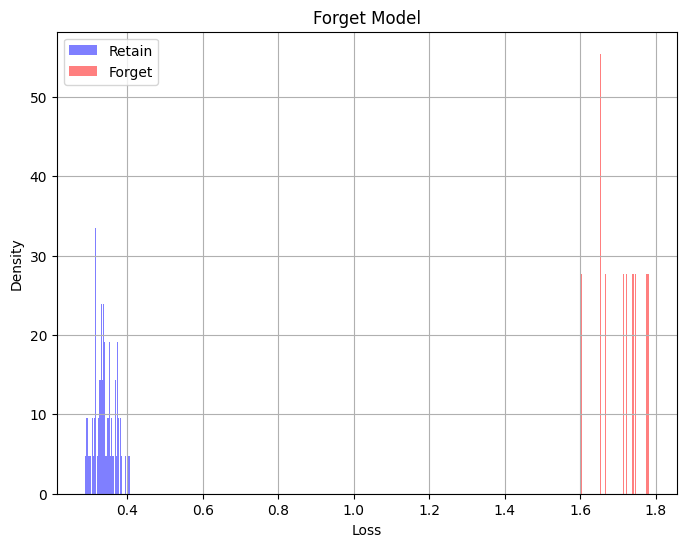

Forget Model MIA Score: 1.0000
Retain Set Accuracy: 88.62%
Forget Set Accuracy: 37.18%
Test Set Accuracy: 77.86%


In [87]:
evaluate_unlearning(forget_model, retain_loader, forget_loader, test_loader)

The graph shows the loss distribution for retained and forgotten classes following the unlearning process.<br>
Retained classes exhibit consistently low loss values, reflecting that the model's performance on these classes remains intact. In contrast, the forgotten class shows a significantly higher and more dispersed loss distribution, which confirms the success of the unlearning mechanism. However, this stark separation indicates that the model has aggressively forgotten the target class, potentially treating its samples as outliers. While effective in achieving the goal of unlearning, this sharp differentiation suggests room for refining the process to strike a better balance between forgetting and generalization.<br>
***An extended comment is detailed in the Report***

#### **THE REPORT IS IN A PDF DOCUMENT ATTACHED TO THE EMAIL**